In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/recommender_system/


/content/drive/MyDrive/recommender_system


In [4]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
sys.path.append('/content/drive/MyDrive/recommender_system/src')


In [6]:
f = "data/ml-32m/ratings.csv"

In [7]:
split_ratio = 0.9
from split_train_test import split_train_test

(userid_to_idx, idx_to_userid, data_train_by_user, data_test_by_user,
movieid_to_idx, idx_to_movieid, data_train_by_movie, data_test_by_movie) = split_train_test(f, split_ratio)

In [8]:
from train_parallelize import *
k = 20
lamda = 0.01
gamma = 0.01
tau = 0.1
N = 20
(user_biases, movie_biases, u, v,costs_train,
      rmse_train,  costs_test, rmse_test) = train(data_train_by_user, data_train_by_movie, data_test_by_user,
                                                   k,lamda, gamma,tau, N)

 k=20
lamda=0.01, gamma=0.01, tau=0.1

Iteration   1/20	Train Loss: 111709.9248	Train RMSE: 0.8083	Test Loss: 30064.6543	Test RMSE: 0.8822	Time: 101.18s
Iteration   5/20	Train Loss: 85035.7682	Train RMSE: 0.6813	Test Loss: 27979.6637	Test RMSE: 0.7821	Time:  97.54s
Iteration  10/20	Train Loss: 82165.8221	Train RMSE: 0.6719	Test Loss: 26739.9244	Test RMSE: 0.7741	Time: 118.82s
Iteration  15/20	Train Loss: 80936.4301	Train RMSE: 0.6696	Test Loss: 25903.6519	Test RMSE: 0.7723	Time: 119.51s
Iteration  20/20	Train Loss: 80095.8013	Train RMSE: 0.6686	Test Loss: 25239.5454	Test RMSE: 0.7714	Time: 127.28s
Total duration: 564.33s


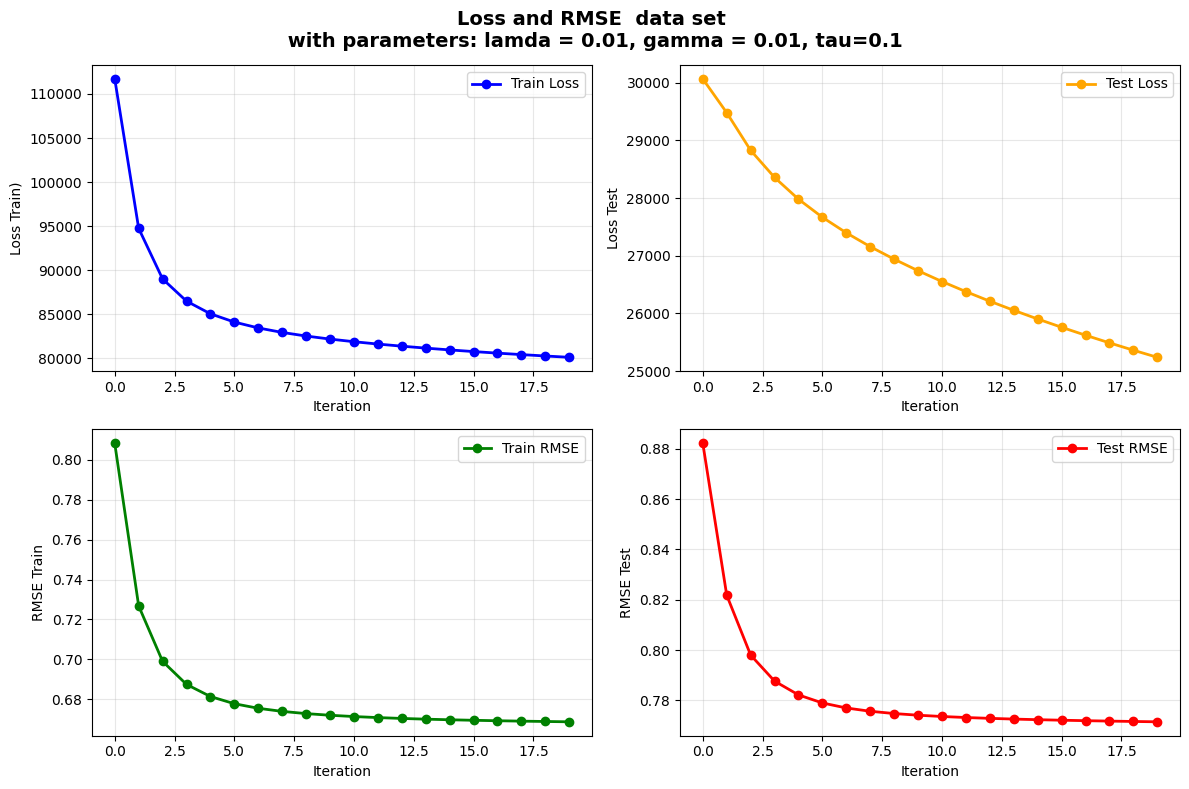

In [9]:

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(costs_train, label="Train Loss", color='blue', linewidth=2, marker='o')
ax[0, 0].set_ylabel("Loss Train)")
ax[0, 0].set_xlabel("Iteration")
ax[0, 0].legend()
ax[0, 0].grid(True, alpha=0.3)

ax[0, 1].plot(costs_test, label="Test Loss", color='orange', linewidth=2, marker='o')
ax[0, 1].set_ylabel("Loss Test")
ax[0, 1].set_xlabel("Iteration")
ax[0, 1].legend()
ax[0, 1].grid(True, alpha=0.3)

ax[1, 0].plot(rmse_train, label="Train RMSE", color='green', linewidth=2, marker='o')
ax[1, 0].set_ylabel("RMSE Train")
ax[1, 0].set_xlabel("Iteration")
ax[1, 0].legend()
ax[1, 0].grid(True, alpha=0.3)

ax[1, 1].plot(rmse_test, label="Test RMSE", color='red', linewidth=2, marker='o')
ax[1, 1].set_ylabel("RMSE Test")
ax[1, 1].set_xlabel("Iteration")
ax[1, 1].legend()
ax[1, 1].grid(True, alpha=0.3)

fig.suptitle(f"Loss and RMSE  data set \n with parameters: lamda = {lamda}, gamma = {gamma}, tau={tau} ", fontsize=14, fontweight='bold')
plt.tight_layout()

#path = "../figure_saved"
#name_file = f"rating_distribution_{M_data}.pdf"

#os.makedirs(path, exist_ok=True)

#plt.savefig(os.path.join(path, name_file), format='pdf')

plt.show()


In [10]:
movies_file="data/ml-32m/movies.csv"
movies_df = pd.read_csv(movies_file)

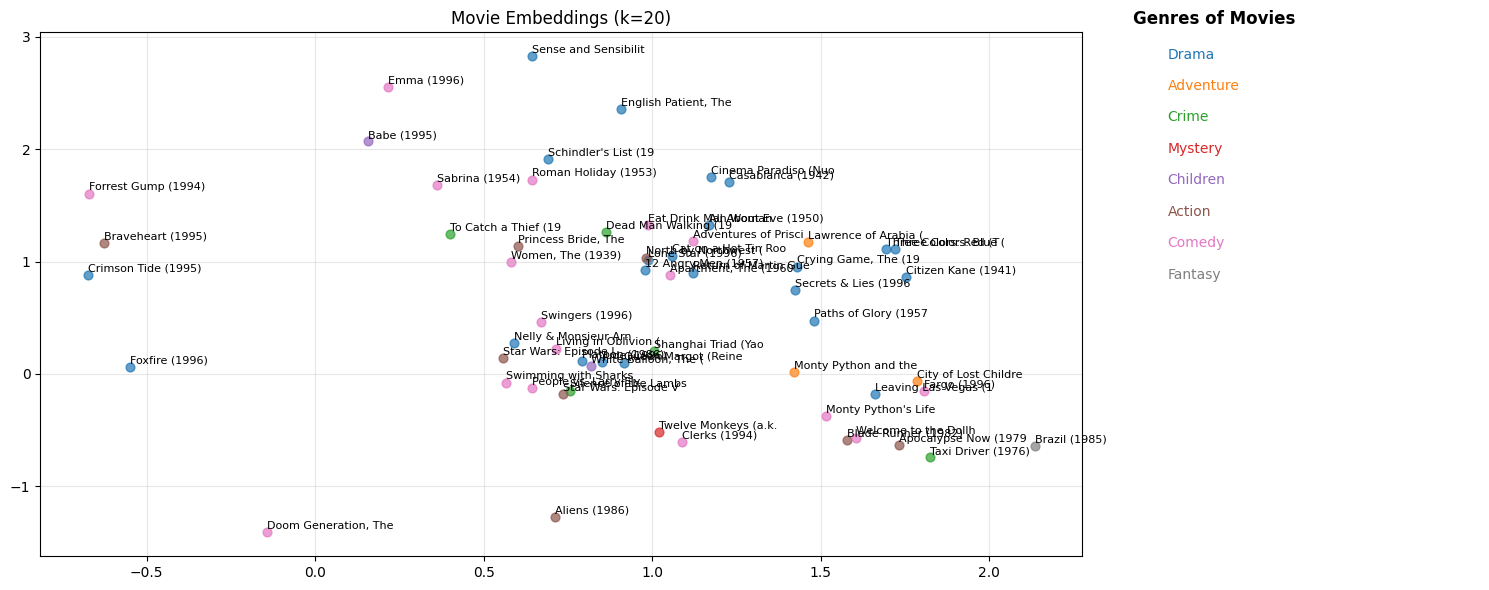

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
v_2d = pca.fit_transform(v)

movie_info_pca = pd.DataFrame({
    "movieId": [int(movieid) for movieid in idx_to_movieid],
    "x": v_2d[:, 0],
    "y": v_2d[:, 1]
}).merge(movies_df, on="movieId", how="left")

first = 60
movie_selected = movie_info_pca.head(first).copy()
movie_selected["main_genre"] = movie_selected["genres"].fillna("Unknown").apply(lambda g: g.split('|')[0])


unique_genres = movie_selected["main_genre"].unique()
colors = plt.cm.tab10(range(len(unique_genres)))
color_map = dict(zip(unique_genres, colors))
movie_selected["color"] = movie_selected["main_genre"].map(color_map)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

for g in unique_genres:
    sub = movie_selected[movie_selected["main_genre"] == g]
    ax1.scatter(sub["x"], sub["y"], color=color_map[g], s=40, alpha=0.7, label=g)
    for _, row in sub.iterrows():
        ax1.text(row["x"] + 0.00, row["y"] + 0.03, row["title"][:20], fontsize=8)

ax1.set_title(f"Movie Embeddings (k={k})")
ax1.grid(True, alpha=0.3)

ax2.axis('off')
ax2.set_title("Genres of Movies", loc="left", fontsize=12, fontweight='bold')

for i, g in enumerate(unique_genres):
    ax2.text(0.1, 0.95 - i*0.06, f"{g}", fontsize=10, color=color_map[g])
# path = "figure_saved"
# name_file = f"random_Movie_embedding_vector_with(k={k}).pdf"

# os.makedirs(path, exist_ok=True)

# plt.savefig(os.path.join(path, name_file), format='pdf')
# #plt.savefig('movie_embeddings_umap.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [12]:
def multi_search_movie_embeddings(keywords, movie_metadata, movieid_to_idx, v):
    all_results = []

    for word in keywords:
        word = word.lower().strip()
        matches = movie_metadata[movie_metadata['title'].str.lower().str.contains(word, na=False)]
        matches = matches.copy()
        matches['search_keyword'] = word
        matches['embedding_index'] = matches['movieId'].map(lambda mid: movieid_to_idx.get(str(mid), None))
        matches = matches.dropna(subset=['embedding_index']).astype({'embedding_index': int})
        matches['vector'] = matches['embedding_index'].apply(lambda i: v[i])

        all_results.append(matches[['movieId', 'title', 'embedding_index', 'vector', 'search_keyword']])


    combined = pd.concat(all_results, ignore_index=True)
    return combined
keywords = ["toy story", "lord of the rings", "home alone"]
results = multi_search_movie_embeddings(keywords, movies_df, movieid_to_idx, v)
display(results)


,movieId,title,embedding_index,vector,search_keyword
0,1,Toy Story (1995),415,"[-1.2412132824761912, 0.5207546746502203, 0.84...",toy story
1,3114,Toy Story 2 (1999),1287,"[-1.0818326843062631, 0.5033185032056173, -0.0...",toy story
2,78499,Toy Story 3 (2010),3080,"[-0.0849201354799497, 0.047236763173811994, 0....",toy story
3,106022,Toy Story of Terror (2013),12260,"[0.2115208946234444, 0.13702973464744833, -0.2...",toy story
4,115875,Toy Story Toons: Hawaiian Vacation (2011),8493,"[0.10899844983825469, -0.06262441453904659, -0...",toy story
5,115879,Toy Story Toons: Small Fry (2011),17545,"[-0.15971693126750378, 0.04074123676797228, -0...",toy story
6,120468,Toy Story Toons: Partysaurus Rex (2012),33361,"[0.1761798470974433, -0.009570516492746785, -0...",toy story
7,120474,Toy Story That Time Forgot (2014),11771,"[0.14397093194704813, 0.05032601697530374, 0.0...",toy story
8,201588,Toy Story 4 (2019),6787,"[0.0209647666273845, 0.12223643406487439, 0.26...",toy story
9,2116,"Lord of the Rings, The (1978)",1819,"[-0.5264776186002553, -2.4333689370371654, -0....",lord of the rings


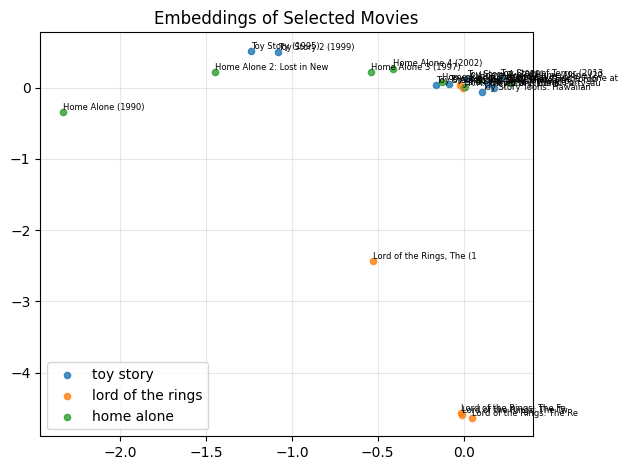

In [13]:
plt.figure()
colors = plt.cm.tab10(range(len(keywords)))
color_map = dict(zip(keywords, colors))

for word in keywords:
    subset = results[results['search_keyword'] == word]
    plt.scatter(subset['vector'].apply(lambda x: x[0]),
                subset['vector'].apply(lambda x: x[1]),
                s=20, alpha=0.8, label=word, color=color_map[word])
    for _, row in subset.iterrows():
        plt.text(row['vector'][0] + 0.00, row['vector'][1] + 0.03, row['title'][:25], fontsize=6)

plt.title("Embeddings of Selected Movies")
plt.legend()
plt.grid(True, alpha=0.3)
# path = "figure_saved"
# name_file = f"clear_selected_Movie_embedding_vector_with(k={k}).pdf"

# os.makedirs(path, exist_ok=True)

# plt.savefig(os.path.join(path, name_file), format='pdf')
# #plt.savefig('movie_embeddings_umap.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

plt.show()


In [14]:
movies_df[movies_df['title'].str.contains("Lord of the Ring", case=False, na=False)]


,movieId,title,genres
2026,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4888,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5841,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7029,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
71797,231829,A Passage to Middle-earth: Making of 'Lord of ...,Documentary
79743,267392,"J.R.R. Tolkien and the Birth Of ""The Lord of t...",(no genres listed)


In [15]:
mId = ['2116','4993','5952','7153']
list_id = []
for e in mId:
  ind = movieid_to_idx[e]
  list_id.append(ind)
print(list_id)

[1819, 339, 596, 613]


In [16]:
from recommendation import *

dummy_data = [(339, 5.0)]

recomm = get_user_recommendations(dummy_data, movie_biases, v,
                                  idx_to_movieid, movies_df,
                                  k, lamda, gamma, tau,
                                  top_k=10, bias_weight=0.05)
lord_ring_recommendation = pd.DataFrame(recomm[0])
lord_ring_recommendation

,movie_idx,movie_id,title,genres,score
0,613,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,3.538168
1,596,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,3.508838
2,339,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,3.502729
3,888,98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX,1.997618
4,902,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX,1.830656
5,1152,118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy,1.637520
6,1819,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,1.180620
7,0,17,Sense and Sensibility (1995),Drama|Romance,1.127350
8,8,110,Braveheart (1995),Action|Drama|War,1.077608
9,15,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1.046548


In [17]:
table_recommendation_lord = lord_ring_recommendation[["title","score"]].to_latex(index=False, float_format="%.3f")
with open("final_recommend.tex", "w") as f:
    f.write(table_recommendation_lord)